# Introduction to Algorithmic Disparity: COMPAS

Today we are going to study an extremely famous investigation into algorithmic decision-making in the sphere of criminal justice by @angwin2022machine, originally written for ProPublica in 2016. This investigation significantly accelerated the pace of research into bias and fairness in machine learning, due in combination to its simple message and publicly-available data.

[It's helpful to look at a [sample form](https://www.documentcloud.org/documents/2702103-Sample-Risk-Assessment-COMPAS-CORE) used for feature collection in the COMPAS risk assessment.]{.aside}

You may have already read about the COMPAS algorithm in [the original article at ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). Our goal today is to reproduce some of the main findings of this article and set the stage for a more systematic treatment of bias and fairness in machine learning. 

*Parts of these lecture notes are inspired by the [original ProPublica analysis](https://github.com/propublica/compas-analysis) and Allen Downey's [expository case study](https://github.com/AllenDowney/RecidivismCaseStudy) on the same data.*

## Data Preparation

[This data set was obtained by @angwin2022machine through a public records request. The data comprises two years worth of COMPAS scoring in Broward County, Florida.]{.aside}
Let's first obtain the data. I've hosted a copy on the course website, so we can download it using a URL. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
np.set_printoptions(precision = 3)
pd.set_option('display.precision', 3)

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/compas/compas.csv"
compas = pd.read_csv(url)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


For today we are only going to consider a subset of columns. 

In [2]:
compas
#v_decile_score predicts if the person will be arrested again. The higher, the more likely.
#two_year_recid is if the last two years they committed another offense

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


We are also only going to consider white (Caucasian) and Black (African-American) defendants: 

In [3]:
cols = ["sex", "race", "decile_score", "two_year_recid"]
compas = compas[cols]

Our data now looks like this: 

In [4]:
is_white = compas["race"] == "Caucasian" #is_white returns booleans
is_black = compas["race"] == "African-American"
#compares the booleans
compas = compas[is_white | is_black]
compas = compas.copy()
compas.head()

,sex,race,decile_score,two_year_recid
1,Male,African-American,3,1
2,Male,African-American,4,1
3,Male,African-American,8,0
6,Male,Caucasian,6,1
8,Female,Caucasian,1,0


## Preliminary Explorations
 
Let's do some quick exploration of our data. How many defendants are present in this data of each sex? 

In [5]:
compas.groupby("sex").size()

sex
Female    1219
Male      4931
dtype: int64

What about race? 

In [6]:
compas.groupby("race").size()

race
African-American    3696
Caucasian           2454
dtype: int64

The decile score is the algorithm's prediction. Higher decile scores indicate that, according to the COMPAS model, the defendant has higher likelihood to be charged with a crime within the next two years. In the framework we've developed in this class, you can think of the decile score as being produced by computing a score like $s_i = \langle \mathbf{w}, \mathbf{x}_i \rangle$ for each defendant $i$, and then dividing these into the lowest 10% (decile score 1), the next 10% (decile score 2), the next 10% (decile score 3) and so on. 

The easiest way to see how this looks is with a bar chart, which we can make efficiently using the `seaborn` (`sns`) package. 

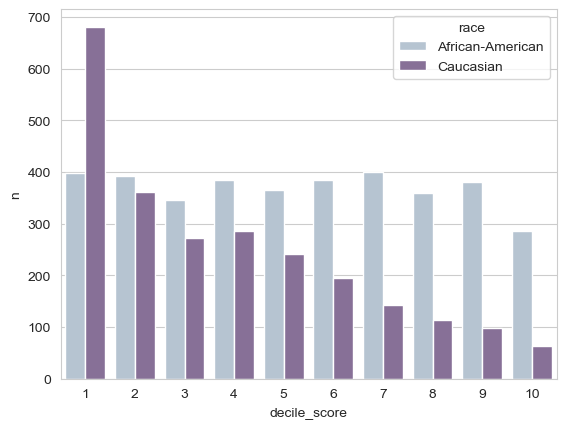

In [7]:
counts = compas.groupby(["race", "decile_score"]).size().reset_index(name = "n")
p = sns.barplot(data = counts, 
                x = "decile_score", 
                y = "n", 
                hue = "race", 
                palette = "BuPu", 
                saturation = 0.5)

You may notice that the number of white defendants who receive a given decile score tends to decrease as the score increases, whereas the number of Black defendants remains relatively constant. 

Let's also take a look at the recidivism rate in the data: 

In [8]:
compas["two_year_recid"].mean()

0.4661788617886179

So, in these data, approximately 47% of all defendants went on to be charged of another crime within the next two years. This is sometimes called the *prevalence* of the outcome. Although this is not a "good" outcome, it is labeled `1` in the target data and so we refer to this as the "positive" outcome. *Prevalence* without further specification usually refers to prevalence of the positive outcome. 

The base rate of prediction accuracy in this problem is 53%: if we always guessed that the defendant was not arrested within two years, we would be right 53% of the time. 

We can also compute the prevalence broken down by race of the defendant: 

In [9]:
compas.groupby("race")["two_year_recid"].mean()

race
African-American    0.514
Caucasian           0.394
Name: two_year_recid, dtype: float64

::: {.column-margin}

When interpreting these different prevalences, it is important to remember that 

- Race is itself a socially-constructed system of human categorization invented by humans with political and economic motives to describe other humans as property [@bonilla-silvaRacismRacistsColorblind2018].  
- The relation between arrest and actual criminal offense can display racial bias, with effects varying by geography [@fogliatoValidityArrestProxy2021]. 
- Decisions about which behaviors are criminal are contingent political decisions which have, historically, fallen hardest on Black Americans [@yusefCriminalizingRaceRacializing2017]. 

:::

The prevalences between the two groups are substantially different. This difference will have major consequences later on for the possibility of different kinds of fairness in classifiers. 


We're going to treat the COMPAS algorithm as a binary classifier, but you might notice a problem: the algorithm's prediction is the `decile_score` column, which is not actually a `0`-`1` label. Following the analysis of @angwin2022machine, we are going to construct a new binary column in which we say that a defendant is `predicted_high_risk` if their `decile_score` is larger than 4. 

In [10]:
compas["predicted_high_risk"] = compas["decile_score"] > 4 # if greater than four, you are a high risk

Now that we've done that, we can ask: how likely are Black and white defendants to receive positive predictions in this data?

In [11]:
compas.groupby("race")[["two_year_recid", "predicted_high_risk"]].mean()

,two_year_recid,predicted_high_risk
race,,
African-American,0.514,0.588
Caucasian,0.394,0.348


Black defendants are substantially more likely to receive a positive prediction than white defendants, and the disparity is larger than the observed prevalence of the positive outcome. 

::: {.callout-note}

## Fairness (Part 1)

Is this *fair*? What is your gut telling you? Yes, no, possibly? What information would you need in order to make a judgment? What is the *principle* on which your judgment rests? 

:::

## The ProPublica Findings

Let's now ask a few questions about the the predictive accuracy of this algorithm. First, how accurate it is it overall? 

In [12]:
compas["correct_prediction"] = compas["predicted_high_risk"] == compas["two_year_recid"]
compas["correct_prediction"].mean()

0.6508943089430894

Recall that the base rate in this problem is 53%, so our accuracy is somewhat better than random guessing. 

What about the accuracy on Black and white defendants separately?

In [13]:
compas.groupby(["race"])["correct_prediction"].mean()

race
African-American    0.638
Caucasian           0.670
Name: correct_prediction, dtype: float64

The overall accuracies for Black and white defendants are comparable, and both are somewhat higher than the base rate of 53%. 

What about the error rates? Here is a simple calculation which computes the false positive rate (FPR) in the first row and the true positive rate (TPR) on the bottom row: 

In [14]:
compas.groupby(["two_year_recid"])["predicted_high_risk"].mean()
#checking false postive rate on top row (assessed at being at a high risk of committing another crime)
#true positive rate on bottom row 

two_year_recid
0    0.352
1    0.654
Name: predicted_high_risk, dtype: float64

However, and this was the main finding of the ProPublica study, the FPR and FNR are very different when we break down the data by race:

In [15]:
compas.groupby(["two_year_recid", "race"])["predicted_high_risk"].mean()


two_year_recid  race            
0               African-American    0.448
                Caucasian           0.235
1               African-American    0.720
                Caucasian           0.523
Name: predicted_high_risk, dtype: float64

The false positive rate for Black defendants is much higher than the false positive rate for white defendants. This was the main finding of @angwin2022machine. The FPR of 44% for Black defendants means that, out of every 100 Black defendants who *in fact will not commit another crime*, the algorithm nevertheless predicts that 44 of them will. In contrast, the FPR of 23% for white defendants indicates that only 23 out of 100 non-recidivating white defendants would be predicted to recidivate. 

There are a few ways in which we can think of this result as reflecting bias: 

- The algorithm has learned an implicit pattern wherein Black defendants are intrinsically more "criminal" than white defendants, even among people who factually never committed another crime. This is a bias in the patterns that the algorithm has learned in order to formulate its predictions. This is related to the idea of ***representational bias***, in which algorithms learn and reproduce toxic stereotypes about certain groups of people. 
- Regardless of how the algorithm forms its predictions, the *impact* of the algorithm being used in the penal system is that more Black defendants will be classified as high-risk, resulting in more denials of parole, bail, early release, or other forms of freedom from the penal system. So, the algorithm has disparate *impact* on people. This is sometimes called **allocative** or **distributional** bias: bias in how resources or opportunities (in this case, freedom) are allocated or distributed between groups. 

[Sometimes predictive equality is also defined to require that the false negative rates (FNRs) be equal across the two groups as well.]{.aside}

We can think about the argument of @angwin2022machine as a two-step argument: 

> 1. The COMPAS algorithm has disparate error rates by race. 
> 2. **Therefore**, the COMPAS algorithm is unjustly biased with respect to race. 

This argument implicitly equates equality of error rates with lack of bias. 

::: {.callout-note}

## Fairness (Part 2)

1. Suppose that we developed an alternative algorithm in which the false positive rates were equal, but there were still more positive predictions for Black defendants overall. Would that be enough to ensure fairness? 
2. Suppose that we developed an alternative prediction algorithm in which the rate of positive prediction was the same across racial groups, but the false positive rates were different. Would that be to ensure fairness? 

:::

## The Rebuttal

@angwin2022machine kicked off a vigorous discussion about what it means for an algorithm to fair and how to measure deviations from bias. In particular, Northpointe, the company that developed COMPAS, issued a report @flores2016false in which they argued that their algorithm *was* fair. Their argument is based on an idea of fairness which is sometimes called *sufficiency* @corbett-daviesAlgorithmicDecisionMaking2017. 

Here's the intuition expressed by sufficiency. Imagine that you and your friend both received an A- in Data Structures. Suppose, however, that the instructor says different things to each of you: 

- To you, the instructor says: "*You did fine in this class, but I don't think that you are prepared to take Computer Architecture. I gave you a higher grade than I would normally because you wear cool hats in class.*"
- To your friend, the instructor says: "*You did fine in this class and I think you are prepared to take Computer Architecture. Some students got a bump in their grade because they are cool-hat-wearers, but you didn't get that benefit."

Feels unfair, right? The instructor is saying that:

> *What a grade means for you in terms of your future success depends on your identity group.* 

::: {.callout-note}

Suppose that you heard this, but instead of cool hats it was because you are a member of an identity group that "needs some help" in order to achieve equitable representation in the CS major. How would you feel? Would that feel fair to you? 

:::

We'll formally define sufficiency in a future lecture. For now, let's use an informal definition: 

> Sufficiency means that a positive prediction means the same thing for future outcomes for each racial group. 

To operationalize this idea, we are looking for the rate of re-arrest to be the same between (a) Black defendants who received a positive prediction and (b) white defendants who received a positive prediction. 

Let's check this: 

The rates of rearrest are relatively similar between groups when controlling for the predictions they collectively received. Formal statistical hypothesis tests are typically used to determine whether this difference is sufficiently "real" to warrant correction. In most of the published literature, scholars have considered that the two rates are sufficiently close that we should instead simply say that COMPAS appears to be relatively close to satisfying sufficiency. 

Indeed, in a rejoinder article published by affiliates of the company Northpointe which produced COMPAS, the fact that COMPAS satisfies sufficiency is one of the primary arguments [@flores2016false].  

## Recap

In these notes, we replicated the data analysis of @angwin2022machine, finding that the COMPAS algorithm has disparate error rates between Black and white defendants. We introduced the idea that *fairness* actually has several different facets in our moral intuitions, and found that the COMPAS algorithm satisfies one of them (sufficiency: equal scores mean the same thing regardless of your group membership) but not the others (equal prediction rates and equal error rates). 


## Some Questions Moving Forward

1. **Can we have it all?** Could we modify the COMPAS algorithm in such a way that it satisfies all the ideas of fairness that we discussed above? Could we then call it "fair" or "unbiased?"
2. **Are there other ways to define fairness?** Which ones are most compelling to us? Does the right idea of fairness depend on the context in which we apply it? 
3. **How did this happen?** The COMPAS algorithm was never trained on race data about the defendant. How did it happen that this algorithm nevertheless made recommendations at different rates across groups?
3. **Is automated decision-making legitimate in this setting?** Can it be legitimate (just, fair) to use an automated decision-system for making recommendations about parole and sentencing decisions at all? What safeguards and forms of recourse are necessary for the legitimate use of automated decision-making in criminal justice? 
4. **What are the systemic impacts?** Disparate sentencing decisions can have downstream impacts on communities and institutions. How could application of the COMPAS algorithm exacerbate systemic inequalities? 

## References